In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src")

In [3]:
from CompoTree import ComponentTree, Radicals, TSVariants, CharLexicon

In [4]:
ctree = ComponentTree.load()
radicals = Radicals.load()
tsvars = TSVariants.load()
lexicon = CharLexicon.load()

In [5]:
ctree.query("灘", use_flag="first")[0].children

[['氵'], [<⿰:[<⿱:廿⿻口夫>]['隹'](GTKV)>]]

In [6]:
yo_hits = ctree.find("又", max_depth=1, bmp_only=True)
yo_hits_simp = [x for x in yo_hits if tsvars.is_simplified(x[0])]
yo_trad_items = []
for hit_x in yo_hits_simp:
    trad_char = tsvars.convert(hit_x[0])[0]
    if hit_x[0] == "鸡":
        trad_char = "鷄"
    try:
        trad_compo = ctree.select(trad_char, hit_x[1], use_flag="shortest")
        yo_trad_items.append((trad_char, hit_x[0], trad_compo))
    except IndexError as ex:
        print(str(ex), trad_char, hit_x[1])
yo_trad_items

IDC does not match 雙 [⿰0双]


[('變', '变', '攵'),
 ('嘆', '叹', '𦰩'),
 ('權', '权', '雚'),
 ('勸', '劝', '雚'),
 ('鳳', '凤', '𩾏'),
 ('鷄', '鸡', '奚'),
 ('對', '对', <⿱:业𦍌>),
 ('歡', '欢', '雚'),
 ('戲', '戏', '䖒'),
 ('觀', '观', '雚'),
 ('艱', '艰', '𦰩'),
 ('敘', '叙', '攵'),
 ('難', '难', '𦰩'),
 ('鄧', '邓', '登'),
 ('僅', '仅', '堇'),
 ('聖', '圣', '𦔻'),
 ('馭', '驭', '又'),
 ('漢', '汉', '𦰩')]

In [23]:
from collections import defaultdict
chars_set = set()
compo_set = set()
decompo_set = set()
for item_x in yo_trad_items:
    trad_char = item_x[0]
    simp_char = item_x[1]
    chars_set.add(trad_char)
    chars_set.add(simp_char)    
    trad_ortho = ctree.query(trad_char, 
                              max_depth=1, 
                              use_flag="shortest")[0]
    simp_ortho = ctree.query(simp_char,
                              max_depth=1,
                              use_flag="shortest")[0]
    for compo_i in [0, 1]:
        if trad_ortho.idc != simp_ortho.idc:
            continue
        trad_compo = trad_ortho.get_component(compo_i)
        simp_compo = simp_ortho.get_component(compo_i)        
        compo_set.add(str(trad_compo))
        compo_set.add(str(simp_compo))
        decompo_set.add((trad_char, str(trad_compo)))        
        decompo_set.add((simp_char, str(simp_compo)))
        if simp_compo == "又" and simp_compo != trad_compo:                                 
            trad_neighs = [x[0] for x in 
                           ctree.find(trad_compo, max_depth=1, 
                                      use_flag="shortest",
                                      bmp_only=True)]
            trad_neighs = [x for x in trad_neighs if x in lexicon]
            neighs = set(trad_neighs).difference([x[0] for x in yo_trad_items])            
            simp_neighs = [tsvars.convert(x)[0] for x in neighs]
            neigh_chars = neighs | set(simp_neighs)
            chars_set |= neigh_chars            
            for neigh_x in neigh_chars:
                ortho_x = ctree.query(neigh_x, max_depth=1, use_flag="shortest")[0]
                compos_x = set(str(ortho_x.get_component(x)) 
                                 for x in range(len(ortho_x.children)))
                compo_set |= compos_x
                decompo_set |= set((neigh_x, x) for x in compos_x)
    

In [24]:
len(chars_set), len(compo_set), len(decompo_set)

(105, 84, 215)

## Component Matrix

In [37]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [34]:
char_enc = LabelEncoder()
compo_enc = LabelEncoder()
char_enc.fit(list(chars_set))
compo_enc.fit(list(compo_set))

LabelEncoder()

In [35]:
n_char = len(char_enc.classes_)
n_compo = len(compo_enc.classes_)

In [38]:
decompo_matrix = np.zeros((n_char, n_compo), dtype=np.int32)

In [41]:
list(decompo_set)[0]

('鸛', '鳥')

In [42]:
for item_x in decompo_set:
    char_idx = char_enc.transform([item_x[0]])[0]
    compo_idx = compo_enc.transform([item_x[1]])[0]
    decompo_matrix[char_idx, compo_idx] = 1

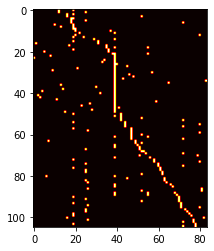

In [49]:
from matplotlib import pyplot as plt
plt.imshow(decompo_matrix, cmap="hot")

In [50]:
from numpy import linalg as la
la.matrix_rank(decompo_matrix)

84

In [51]:
la.qr(decompo_matrix)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.02541163,
         -0.0436212 , -0.03599373],
        [-0.        ,  0.        ,  0.        , ..., -0.02541163,
          0.0436212 ,  0.03599373],
        [-0.        , -0.        ,  0.        , ...,  0.10967355,
          0.35384406, -0.00247368],
        ...,
        [-0.        , -0.        , -0.        , ..., -0.10336757,
          0.01629176,  0.00069453],
        [-0.        , -0.        , -0.        , ..., -0.0165713 ,
         -0.01317802, -0.00218655],
        [-0.        , -0.        , -0.        , ...,  0.0165713 ,
          0.01317802,  0.00218655]]),
 array([[-1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -1.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -1.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -